In [2]:
import pysplit
import pandas as pd
import numpy as np
from wrf import getvar, get_basemap, latlon_coords
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import matplotlib as mpl
import xarray as xr
from itertools import product

In [ ]:
parser = argparse.ArgumentParser(description='Calculating hysplit files.')

parser.add_argument("--climate", choices=["hist", "pgw"], required=True, type=str, help="This is the hist or pgw choice.")
parser.add_argument("--month", choices=["may", "jun", "jul", "aug"], required=True, type=str, help="Storm month as three letter string.")
parser.add_argument("--subregion", required=True, type=str, help="The subregion + number. There is no subregion2")

args=parser.parse_args()

In [ ]:
which_climate=args.climate
which_month=args.month
which_region=args.subregion

In [3]:
which_climate='hist'
which_month='may'
which_region='subregion1'

In [4]:
def get_winddir(comp_brngs):
    md = 270 - comp_brngs
    if md < 0:
        new_md = md + 360
    else:
        new_md = md
    return new_md 

def nan_if(arr, value):
    return np.where(arr == value, np.nan, arr)

wrffile = Dataset('/glade/scratch/molina/basile/wrfout_d01_2002-12-30_18:00:00.nc4')
tfile = getvar(wrffile, 'tk')
m = get_basemap(tfile)
lats, lons = latlon_coords(tfile)

grid_res = 50
xMax,yMax = m(m.urcrnrlon, m.urcrnrlat) 
xMin,yMin = m(m.llcrnrlon, m.llcrnrlat)         
x_range = (xMax-xMin) / 1000 
y_range = (yMax-yMin) / 1000 
numXGrids = round(x_range / grid_res + .5,0) 
numYGrids = round(y_range / grid_res + .5,0)        
xi = np.linspace(xMin, xMax, int(numXGrids))
yi = np.linspace(yMin, yMax, int(numYGrids))

In [5]:
#trajgroup = pysplit.make_trajectorygroup(
#    f'/glade/scratch/molina/basile/{which_climate}_traj_{which_month}/trajid*_{which_region}_ens*_{which_month}*summer*')
trajgroup = pysplit.make_trajectorygroup(
    f'/glade/scratch/molina/basile/{which_climate}_traj_{which_month}/trajid*_{which_region}_ens*_{which_month}*spring*')
print(trajgroup.trajcount)

x_trajs = np.array([np.array(traj.path.coords[:])[::,0][j] for traj in trajgroup for j in range(len(traj.path.coords[:]))]).flatten()
y_trajs = np.array([np.array(traj.path.coords[:])[::,1][j] for traj in trajgroup for j in range(len(traj.path.coords[:]))]).flatten()
x_proj, y_proj = m(x_trajs, y_trajs)

342


In [6]:
for traj in trajgroup:
    try:
        traj.calculate_moistureflux()
    except ValueError:
        print(traj.trajid)
    try:
        traj.calculate_vector()
    except ValueError:
        print(traj.trajid)

In [7]:
print("extract the variable data")
specific_humidity = np.array([traj.data.Specific_Humidity.astype(np.float64).values[j] for traj in trajgroup for j in range(len(traj.data.Specific_Humidity.astype(np.float64).values))]).flatten()
relative_humidity = np.array([traj.data.Relative_Humidity.astype(np.float64).values[j] for traj in trajgroup for j in range(len(traj.data.Relative_Humidity.astype(np.float64).values))]).flatten()
print("mixing ratio")
mixing_ratio = np.array([traj.data.Mixing_Ratio.astype(np.float64).values[j] for traj in trajgroup for j in range(len(traj.data.Mixing_Ratio.astype(np.float64).values))]).flatten()
potential_temperature = np.array([traj.data.Potential_Temperature.astype(np.float64).values[j] for traj in trajgroup for j in range(len(traj.data.Potential_Temperature.astype(np.float64).values))]).flatten()
print("temp")
temperature = np.array([traj.data.Temperature.astype(np.float64).values[j] for traj in trajgroup for j in range(len(traj.data.Temperature.astype(np.float64).values))]).flatten()
moisture_flux = np.array([traj.data.Moisture_Flux.astype(np.float64).values[j] for traj in trajgroup for j in range(len(traj.data.Moisture_Flux.astype(np.float64).values))]).flatten()
print("mflux")
x_mflux = np.array([x_trajs[i] for i,j in enumerate(moisture_flux) if np.isfinite(j)]).flatten()
y_mflux = np.array([y_trajs[i] for i,j in enumerate(moisture_flux) if np.isfinite(j)]).flatten()
x_flux, y_flux = m(x_mflux, y_mflux)
moisture_flux = np.array([i for i in moisture_flux if np.isfinite(i)]).flatten()
print("dist")
distance_ptp = np.array([traj.data.Distance_ptp.astype(np.float64).values[j] for traj in trajgroup for j in range(len(traj.data.Distance_ptp.astype(np.float64).values))]).flatten()
bearings_ptp = np.array([traj.data.bearings_ptp.astype(np.float64).values[j] for traj in trajgroup for j in range(len(traj.data.bearings_ptp.astype(np.float64).values))]).flatten()
bearings_ptp = np.degrees(bearings_ptp)

extract the variable data
mixing ratio
temp
mflux
dist


In [8]:
print('Computing along traj wind direction...')
wind_speed = np.divide(distance_ptp, 3600)
compass_bearings = (bearings_ptp + 360) % 360
wind_direction = []
wind_u = []
wind_v = []
for k in range(len(compass_bearings)):
    if compass_bearings[k] == 0:
        wind_direction.append(0)
        wind_u.append(0)
        wind_v.append(0)                               
    else:
        wind_direction.append(get_winddir(compass_bearings[k]))
        wind_u.append(wind_speed[k]*np.cos(np.deg2rad(wind_direction[k])))
        wind_v.append(wind_speed[k]*np.sin(np.deg2rad(wind_direction[k])))
u_component = np.array(wind_u)
v_component = np.array(wind_v)

Computing along traj wind direction...


In [13]:
print("histograms")
mflux_freq, _, _ = np.histogram2d(y_flux, x_flux, bins=(yi, xi))
freq_grid, _, _ = np.histogram2d(y_proj, x_proj, bins=(yi, xi))       
mflux2d, _, _ = np.histogram2d(y_flux, x_flux, bins=(yi, xi), weights=moisture_flux, normed=False)
sh2d, _, _ = np.histogram2d(y_proj, x_proj, bins=(yi, xi), weights=specific_humidity, normed=False)
rh2d, _, _ = np.histogram2d(y_proj, x_proj, bins=(yi, xi), weights=relative_humidity, normed=False)
mr2d, _, _ = np.histogram2d(y_proj, x_proj, bins=(yi, xi), weights=mixing_ratio, normed=False)
pt2d, _, _ = np.histogram2d(y_proj, x_proj, bins=(yi, xi), weights=potential_temperature, normed=False)
t2d, _, _ = np.histogram2d(y_proj, x_proj, bins=(yi, xi), weights=temperature, normed=False)
u_wind, _, _ = np.histogram2d(y_proj, x_proj, bins=(yi, xi), weights=u_component, normed=False)  
v_wind, _, _ = np.histogram2d(y_proj, x_proj, bins=(yi, xi), weights=v_component, normed=False)
velocity, _, _ = np.histogram2d(y_proj, x_proj, bins=(yi, xi), weights=wind_speed, normed=False)

mflux_grid = np.zeros(mflux2d.shape)
sh_grid = np.zeros(sh2d.shape)
rh_grid = np.zeros(rh2d.shape)
mr_grid = np.zeros(mr2d.shape)
pt_grid = np.zeros(pt2d.shape)
t_grid = np.zeros(t2d.shape)
u_grid = np.zeros(u_wind.shape)
v_grid = np.zeros(v_wind.shape)
velocity_grid = np.zeros(velocity.shape)

histograms


In [14]:

print("create means")
for i, j in product(range(len(mflux2d[:,0])),range(len(mflux2d[0,:]))):
    if np.isfinite(mflux2d[i,j]):                    
        if mflux2d[i,j] != 0.0:
            mflux_grid[i,j] = mflux2d[i,j]/mflux_freq[i,j]
        else:
            mflux_grid[i,j] = mflux2d[i,j]
    else:
        mflux_grid[i,j] = mflux2d[i,j]
    if np.isfinite(sh2d[i,j]):                    
        if sh2d[i,j] != 0.0:
            sh_grid[i,j] = sh2d[i,j]/freq_grid[i,j]
        else:
            sh_grid[i,j] = sh2d[i,j]
    else:
        sh_grid[i,j] = sh2d[i,j]
    if np.isfinite(rh2d[i,j]):                    
        if rh2d[i,j] != 0.0:
            rh_grid[i,j] = rh2d[i,j]/freq_grid[i,j]
        else:
            rh_grid[i,j] = rh2d[i,j]
    else:
        rh_grid[i,j] = rh2d[i,j]
        
    if np.isfinite(mr2d[i,j]):                    
        if mr2d[i,j] != 0.0:
            mr_grid[i,j] = mr2d[i,j]/freq_grid[i,j]
        else:
            mr_grid[i,j] = mr2d[i,j]
    else:
        mr_grid[i,j] = mr2d[i,j]
        
    if np.isfinite(pt2d[i,j]):                    
        if pt2d[i,j] != 0.0:
            pt_grid[i,j] = pt2d[i,j]/freq_grid[i,j]
        else:
            pt_grid[i,j] = pt2d[i,j]
    else:
        pt_grid[i,j] = pt2d[i,j]
        
    if np.isfinite(t2d[i,j]):                    
        if t2d[i,j] != 0.0:
            t_grid[i,j] = t2d[i,j]/freq_grid[i,j]
        else:
            t_grid[i,j] = t2d[i,j]
    else:
        t_grid[i,j] = t2d[i,j]
        
    if np.isfinite(u_wind[i,j]):
        if u_wind[i,j] != 0.0:
            u_grid[i,j] = u_wind[i,j]/freq_grid[i,j]
        else:
            u_grid[i,j] = u_wind[i,j]
    else:
        u_grid[i,j] = u_wind[i,j]     
    if np.isfinite(v_wind[i,j]):
        if v_wind[i,j] != 0.0:
            v_grid[i,j] = v_wind[i,j]/freq_grid[i,j]
        else:
            v_grid[i,j] = v_wind[i,j]
    else:
        v_grid[i,j] = v_wind[i,j]
    if np.isfinite(velocity[i,j]):
        if velocity[i,j] != 0.0:
            velocity_grid[i,j] = velocity[i,j]/freq_grid[i,j]
        else:
            velocity_grid[i,j] = velocity[i,j]
    else:
        velocity_grid[i,j] = velocity[i,j]
        

y = np.zeros(len(yi)-1)
x = np.zeros(len(xi)-1)
for a in range(len(y)):
    y[a] = np.nanmean([yi[a],yi[a+1]])
for b in range(len(x)):
    x[b] = np.nanmean([xi[b],xi[b+1]])


ds = xr.Dataset({'frequency':(['lats','lons'],freq_grid),
                 'specific_humidity':(['lats','lons'],sh_grid),
                 'relative_humidity':(['lats','lons'],rh_grid),
                 'mixing_ratio':(['lats','lons'],mr_grid),
                 'potential_temperature':(['lats','lons'],pt_grid),
                 'temperature':(['lats','lons'],t_grid),
                 'moisture_flux':(['lats','lons'],mflux_grid),          
                 'u_wind':(['lats','lons'],u_grid),
                 'v_wind':(['lats','lons'],v_grid),
                 'velocity':(['lats','lons'],velocity_grid),
                },
                 coords={'lats':(['lats'],y),
                         'lons':(['lons'],x)},
                 attrs={'Trajectories and File Author':'Maria J. Molina',
                        'Trajectory Count':str(trajgroup.trajcount)})

ds.to_netcdf(f'/glade/scratch/molina/basile/traj_files/trajfile_{which_month}_{which_region}_{which_climate}.nc')

create means


In [15]:
ds

<xarray.Dataset>
Dimensions:                (lats: 48, lons: 52)
Coordinates:
  * lats                   (lats) float64 2.533e+04 7.6e+04 ... 2.407e+06
  * lons                   (lons) float64 2.531e+04 7.592e+04 ... 2.607e+06
Data variables:
    frequency              (lats, lons) float64 504.0 448.0 672.0 ... 80.0 29.0
    specific_humidity      (lats, lons) float64 8.467 7.838 ... 5.957 4.428
    relative_humidity      (lats, lons) float64 90.09 87.83 ... 68.07 63.38
    mixing_ratio           (lats, lons) float64 8.593 7.95 8.162 ... 6.042 4.483
    potential_temperature  (lats, lons) float64 293.1 293.8 ... 300.4 300.0
    temperature            (lats, lons) float64 284.5 283.2 ... 276.0 272.1
    moisture_flux          (lats, lons) float64 22.86 62.35 ... 22.83 23.44
    u_wind                 (lats, lons) float64 5.112 5.761 ... -3.857 -5.91
    v_wind                 (lats, lons) float64 3.718 5.771 ... -1.34 -0.1391
    velocity               (lats, lons) float64 6.819 9.523 ... 5.338 7.247
Attributes:
    Trajectories and File Author:  Maria J. Molina
    Trajectory Count:              78547

In [4]:
cmap = sns.cubehelix_palette(16, start=.5, rot=-.75, as_cmap=True)
norm = mpl.colors.Normalize(vmin=0,vmax=20)

13


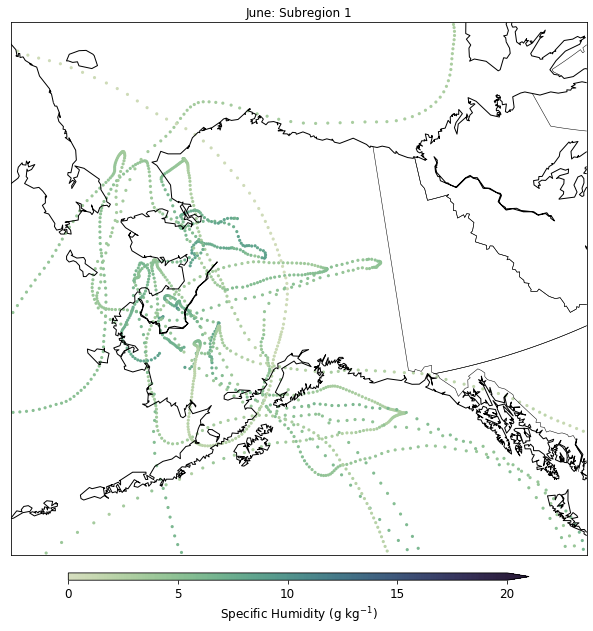

In [22]:
trajgroup = pysplit.make_trajectorygroup(f'/glade/scratch/molina/basile/hist_traj_jun/trajid*_subregion1_ens0_jun*summer*')
print(trajgroup.trajcount)

fig = plt.figure(figsize=(8.,9.))
ax = fig.add_axes([0.0, 0., 1., 1.]) 

ax.set_title('June: Subregion 1', fontsize=12)
#Central Interior

for traj in trajgroup[::]:
        
    bmap_coords = m(traj.path.xy[0], traj.path.xy[1])
    try:
        cs = m.scatter(bmap_coords[0], bmap_coords[1],  
                          s=10, c = traj.data.Specific_Humidity.values,
                          cmap = cmap,
                          vmin=0, vmax=20,
                          edgecolors='none', 
                          zorder=2)
    except AttributeError:
        continue
                   
m.drawstates()
m.drawcoastlines()
m.drawcountries()

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.01125])
bounds = [0,5,10,15,20]
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm,
                                ticks=bounds,
                                orientation='horizontal',
                                extend='max')

cbar.set_label('Specific Humidity (g $\mathregular{kg^{-1}}$)', fontsize=12) 
cbar.ax.tick_params(labelsize=12)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')
                   
plt.show()

69


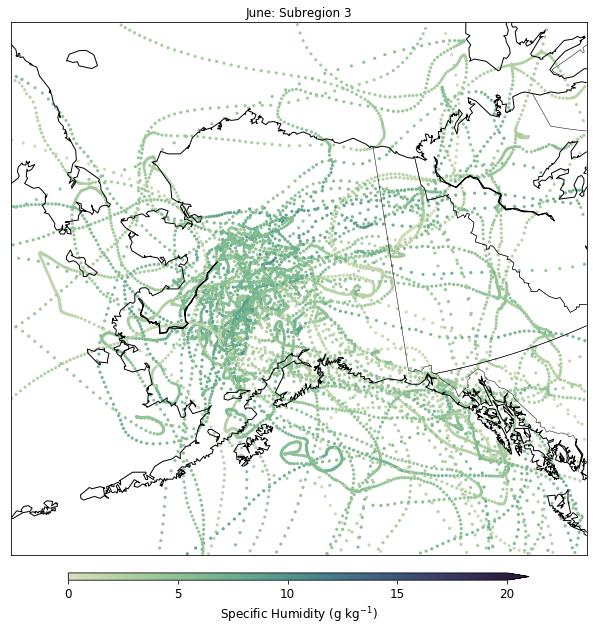

In [23]:
trajgroup = pysplit.make_trajectorygroup(f'/glade/scratch/molina/basile/hist_traj_jun/trajid*_subregion3_ens0_jun*summer*')
print(trajgroup.trajcount)

fig = plt.figure(figsize=(8.,9.))
ax = fig.add_axes([0.0, 0., 1., 1.]) 

ax.set_title('June: Subregion 3', fontsize=12)
#Central Interior

for traj in trajgroup[::]:
        
    bmap_coords = m(traj.path.xy[0], traj.path.xy[1])
    try:
        cs = m.scatter(bmap_coords[0], bmap_coords[1],  
                          s=10, c = traj.data.Specific_Humidity.values,
                          cmap = cmap,
                          vmin=0, vmax=20,
                          edgecolors='none', 
                          zorder=2)
    except AttributeError:
        continue
                   
m.drawstates()
m.drawcoastlines()
m.drawcountries()

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.01125])
bounds = [0,5,10,15,20]
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm,
                                ticks=bounds,
                                orientation='horizontal',
                                extend='max')

cbar.set_label('Specific Humidity (g $\mathregular{kg^{-1}}$)', fontsize=12) 
cbar.ax.tick_params(labelsize=12)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')
                   
plt.show()

15


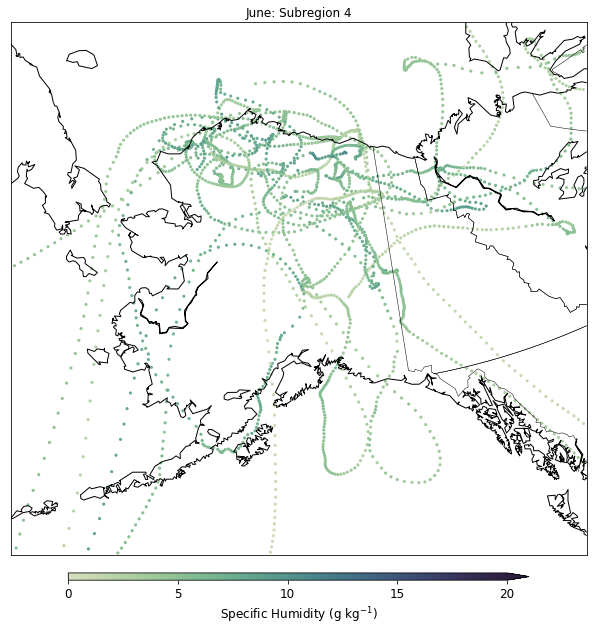

In [24]:
trajgroup = pysplit.make_trajectorygroup(f'/glade/scratch/molina/basile/hist_traj_jun/trajid*_subregion4_ens0_jun*summer*')
print(trajgroup.trajcount)

fig = plt.figure(figsize=(8.,9.))
ax = fig.add_axes([0.0, 0., 1., 1.]) 

ax.set_title('June: Subregion 4', fontsize=12)
#Central Interior

for traj in trajgroup[::]:
        
    bmap_coords = m(traj.path.xy[0], traj.path.xy[1])
    try:
        cs = m.scatter(bmap_coords[0], bmap_coords[1],  
                          s=10, c = traj.data.Specific_Humidity.values,
                          cmap = cmap,
                          vmin=0, vmax=20,
                          edgecolors='none', 
                          zorder=2)
    except AttributeError:
        continue
                   
m.drawstates()
m.drawcoastlines()
m.drawcountries()

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.01125])
bounds = [0,5,10,15,20]
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm,
                                ticks=bounds,
                                orientation='horizontal',
                                extend='max')

cbar.set_label('Specific Humidity (g $\mathregular{kg^{-1}}$)', fontsize=12) 
cbar.ax.tick_params(labelsize=12)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')
                   
plt.show()

18


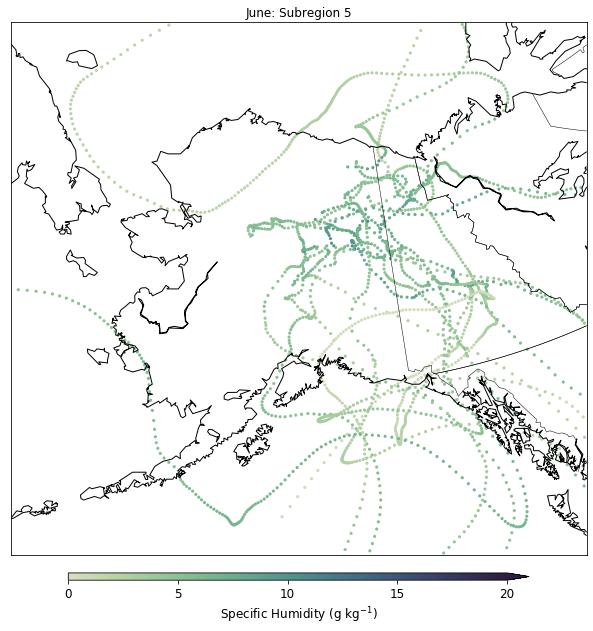

In [25]:
trajgroup = pysplit.make_trajectorygroup(f'/glade/scratch/molina/basile/hist_traj_jun/trajid*_subregion5_ens0_jun*summer*')
print(trajgroup.trajcount)

fig = plt.figure(figsize=(8.,9.))
ax = fig.add_axes([0.0, 0., 1., 1.]) 

ax.set_title('June: Subregion 5', fontsize=12)
#Central Interior

for traj in trajgroup[::]:
        
    bmap_coords = m(traj.path.xy[0], traj.path.xy[1])
    try:
        cs = m.scatter(bmap_coords[0], bmap_coords[1],  
                          s=10, c = traj.data.Specific_Humidity.values,
                          cmap = cmap,
                          vmin=0, vmax=20,
                          edgecolors='none', 
                          zorder=2)
    except AttributeError:
        continue
                   
m.drawstates()
m.drawcoastlines()
m.drawcountries()

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.01125])
bounds = [0,5,10,15,20]
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm,
                                ticks=bounds,
                                orientation='horizontal',
                                extend='max')

cbar.set_label('Specific Humidity (g $\mathregular{kg^{-1}}$)', fontsize=12) 
cbar.ax.tick_params(labelsize=12)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')
                   
plt.show()

38


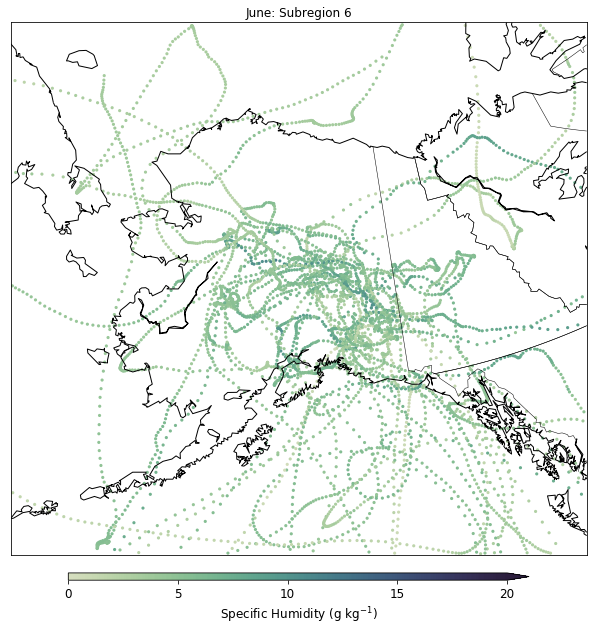

In [26]:
trajgroup = pysplit.make_trajectorygroup(f'/glade/scratch/molina/basile/hist_traj_jun/trajid*_subregion6_ens0_jun*summer*')
print(trajgroup.trajcount)

fig = plt.figure(figsize=(8.,9.))
ax = fig.add_axes([0.0, 0., 1., 1.]) 

ax.set_title('June: Subregion 6', fontsize=12)
#Central Interior

for traj in trajgroup[::]:
        
    bmap_coords = m(traj.path.xy[0], traj.path.xy[1])
    try:
        cs = m.scatter(bmap_coords[0], bmap_coords[1],  
                          s=10, c = traj.data.Specific_Humidity.values,
                          cmap = cmap,
                          vmin=0, vmax=20,
                          edgecolors='none', 
                          zorder=2)
    except AttributeError:
        continue
                   
m.drawstates()
m.drawcoastlines()
m.drawcountries()

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.01125])
bounds = [0,5,10,15,20]
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm,
                                ticks=bounds,
                                orientation='horizontal',
                                extend='max')

cbar.set_label('Specific Humidity (g $\mathregular{kg^{-1}}$)', fontsize=12) 
cbar.ax.tick_params(labelsize=12)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')
                   
plt.show()

In [5]:
grid_res = 50
xMax,yMax = m(m.urcrnrlon, m.urcrnrlat) 
xMin,yMin = m(m.llcrnrlon, m.llcrnrlat)         
x_range = (xMax-xMin) / 1000 
y_range = (yMax-yMin) / 1000 
numXGrids = round(x_range / grid_res + .5,0) 
numYGrids = round(y_range / grid_res + .5,0)        
xi = np.linspace(xMin, xMax, int(numXGrids))
yi = np.linspace(yMin, yMax, int(numYGrids))

In [6]:
grid_res

50

In [7]:
trajgroup = pysplit.make_trajectorygroup(f'/glade/scratch/molina/basile/hist_traj_jun/trajid*_subregion1_ens*_jun*summer*')
print(trajgroup.trajcount)

x_trajs = np.array([np.array(traj.path.coords[:])[::,0][j] for traj in trajgroup for j in range(len(traj.path.coords[:]))]).flatten()
y_trajs = np.array([np.array(traj.path.coords[:])[::,1][j] for traj in trajgroup for j in range(len(traj.path.coords[:]))]).flatten()
x_proj, y_proj = m(x_trajs, y_trajs)

for traj in trajgroup:
    try:
        traj.calculate_moistureflux()
    except ValueError:
        print(traj.trajid)
    try:
        traj.calculate_vector()
    except ValueError:
        print(traj.trajid)
    
specific_humidity = np.array([traj.data.Specific_Humidity.astype(np.float64).values[j] for traj in trajgroup for j in range(len(traj.data.Specific_Humidity.astype(np.float64).values))]).flatten()
moisture_flux = np.array([traj.data.Moisture_Flux.astype(np.float64).values[j] for traj in trajgroup for j in range(len(traj.data.Moisture_Flux.astype(np.float64).values))]).flatten()
x_mflux = np.array([x_trajs[i] for i,j in enumerate(moisture_flux) if np.isfinite(j)]).flatten()
y_mflux = np.array([y_trajs[i] for i,j in enumerate(moisture_flux) if np.isfinite(j)]).flatten()
x_flux, y_flux = m(x_mflux, y_mflux)
moisture_flux = np.array([i for i in moisture_flux if np.isfinite(i)]).flatten()

distance_ptp = np.array([traj.data.Distance_ptp.astype(np.float64).values[j] for traj in trajgroup for j in range(len(traj.data.Distance_ptp.astype(np.float64).values))]).flatten()
bearings_ptp = np.array([traj.data.bearings_ptp.astype(np.float64).values[j] for traj in trajgroup for j in range(len(traj.data.bearings_ptp.astype(np.float64).values))]).flatten()
bearings_ptp = np.degrees(bearings_ptp)

print('Computing along traj wind direction...')
wind_speed = np.divide(distance_ptp, 3600)
compass_bearings = (bearings_ptp + 360) % 360
wind_direction = []
wind_u = []
wind_v = []
for k in range(len(compass_bearings)):
    if compass_bearings[k] == 0:
        wind_direction.append(0)
        wind_u.append(0)
        wind_v.append(0)                               
    else:
        wind_direction.append(get_winddir(compass_bearings[k]))
        wind_u.append(wind_speed[k]*np.cos(np.deg2rad(wind_direction[k])))
        wind_v.append(wind_speed[k]*np.sin(np.deg2rad(wind_direction[k])))
u_component = np.array(wind_u)
v_component = np.array(wind_v)

mflux_freq, _, _ = np.histogram2d(y_flux, x_flux, bins=(yi, xi))
freq_grid, _, _ = np.histogram2d(y_proj, x_proj, bins=(yi, xi))       
mflux2d, _, _ = np.histogram2d(y_flux, x_flux, bins=(yi, xi), weights=moisture_flux, normed=False)
sh2d, _, _ = np.histogram2d(y_proj, x_proj, bins=(yi, xi), weights=specific_humidity, normed=False)
u_wind, _, _ = np.histogram2d(y_proj, x_proj, bins=(yi, xi), weights=u_component, normed=False)  
v_wind, _, _ = np.histogram2d(y_proj, x_proj, bins=(yi, xi), weights=v_component, normed=False)
velocity, _, _ = np.histogram2d(y_proj, x_proj, bins=(yi, xi), weights=wind_speed, normed=False)

mflux_grid = np.zeros(mflux2d.shape)
sh_grid = np.zeros(sh2d.shape)
u_grid = np.zeros(u_wind.shape)
v_grid = np.zeros(v_wind.shape)
velocity_grid = np.zeros(velocity.shape)


for i, j in product(range(len(mflux2d[:,0])),range(len(mflux2d[0,:]))):
    if np.isfinite(mflux2d[i,j]):                    
        if mflux2d[i,j] != 0.0:
            mflux_grid[i,j] = mflux2d[i,j]/mflux_freq[i,j]
        else:
            mflux_grid[i,j] = mflux2d[i,j]
    else:
        mflux_grid[i,j] = mflux2d[i,j]
    if np.isfinite(sh2d[i,j]):                    
        if sh2d[i,j] != 0.0:
            sh_grid[i,j] = sh2d[i,j]/freq_grid[i,j]
        else:
            sh_grid[i,j] = sh2d[i,j]
    else:
        sh_grid[i,j] = sh2d[i,j]
    if np.isfinite(u_wind[i,j]):
        if u_wind[i,j] != 0.0:
            u_grid[i,j] = u_wind[i,j]/freq_grid[i,j]
        else:
            u_grid[i,j] = u_wind[i,j]
    else:
        u_grid[i,j] = u_wind[i,j]     
    if np.isfinite(v_wind[i,j]):
        if v_wind[i,j] != 0.0:
            v_grid[i,j] = v_wind[i,j]/freq_grid[i,j]
        else:
            v_grid[i,j] = v_wind[i,j]
    else:
        v_grid[i,j] = v_wind[i,j]
    if np.isfinite(velocity[i,j]):
        if velocity[i,j] != 0.0:
            velocity_grid[i,j] = velocity[i,j]/freq_grid[i,j]
        else:
            velocity_grid[i,j] = velocity[i,j]
    else:
        velocity_grid[i,j] = velocity[i,j]
        

y = np.zeros(len(yi)-1)
x = np.zeros(len(xi)-1)
for a in range(len(y)):
    y[a] = np.nanmean([yi[a],yi[a+1]])
for b in range(len(x)):
    x[b] = np.nanmean([xi[b],xi[b+1]])

    
ds = xr.Dataset({'frequency':(['lats','lons'],freq_grid),
                 'specific_humidity':(['lats','lons'],sh_grid),
                 'moisture_flux':(['lats','lons'],mflux_grid),          
                 'u_wind':(['lats','lons'],u_grid),
                 'v_wind':(['lats','lons'],v_grid),
                 'velocity':(['lats','lons'],velocity_grid),
                },
                 coords={'lats':(['lats'],y),
                         'lons':(['lons'],x)},
                 attrs={'Trajectories and File Author':'Maria J. Molina',
                        'Trajectory Count':str(trajgroup.trajcount)})

4459


/glade/work/molina/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/pysplit/hypath.py:144: RuntimeWarning: invalid value encountered in arccos
  np.cos(lon[0] - lon)) * 6371) * 1000


Computing along traj wind direction...


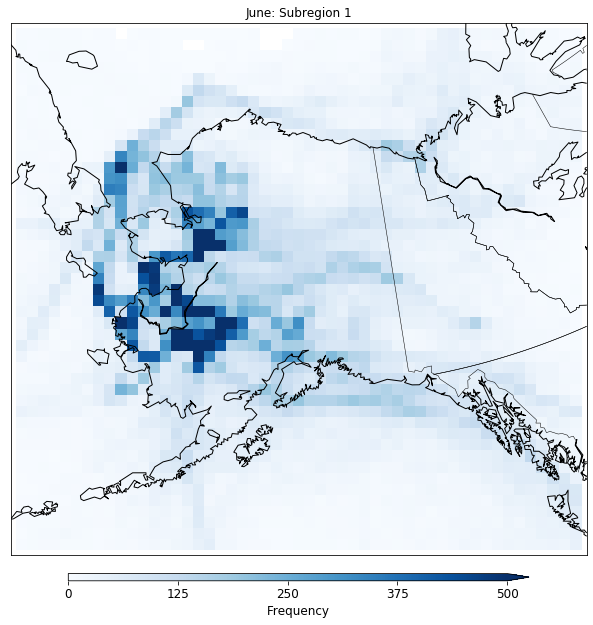

In [8]:
fig = plt.figure(figsize=(8.,9.))
ax = fig.add_axes([0.0, 0., 1., 1.]) 

ax.set_title('June: Subregion 1', fontsize=12)
#Central Interior

pc = m.pcolormesh(ds.lons.values, ds.lats.values, np.ma.masked_where(ds.frequency==0, ds.frequency),
                  cmap="Blues", vmin=0, vmax=2000)

m.drawstates()
m.drawcoastlines()
m.drawcountries()

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.01125])
bounds = [0,125,250,375,500]
newnorm=mpl.colors.Normalize(vmin=0,vmax=500)
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=plt.cm.get_cmap("Blues"),
                                 norm=newnorm,
                                 ticks=bounds,
                                 orientation='horizontal',
                                 extend='max')

cbar.set_label('Frequency', fontsize=12) 
cbar.ax.tick_params(labelsize=12)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')

plt.show()

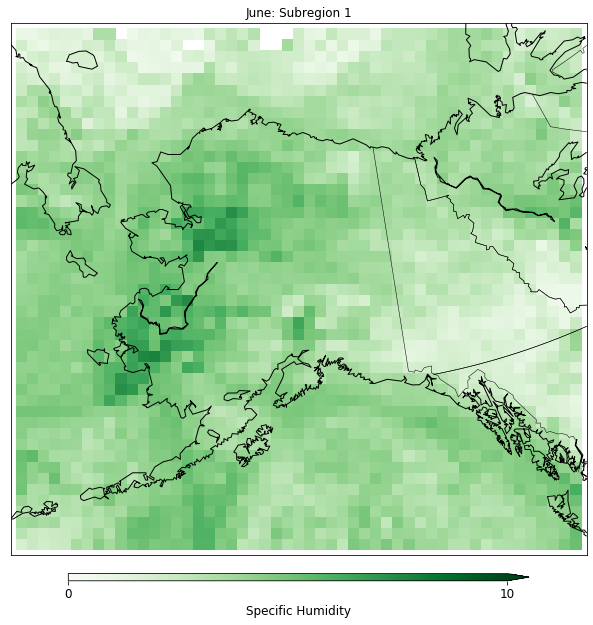

In [9]:
fig = plt.figure(figsize=(8.,9.))
ax = fig.add_axes([0.0, 0., 1., 1.]) 

ax.set_title('June: Subregion 1', fontsize=12)
#Central Interior

pc = m.pcolormesh(ds.lons.values, ds.lats.values, np.ma.masked_where(ds.frequency==0, ds.specific_humidity), 
                  cmap="Greens", vmin=0, vmax=10)

m.drawstates()
m.drawcoastlines()
m.drawcountries()

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.01125])
bounds = [0,10]
newnorm=mpl.colors.Normalize(vmin=0,vmax=10)
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=plt.cm.get_cmap("Greens"),
                                 norm=newnorm,
                                 ticks=bounds,
                                 orientation='horizontal',
                                 extend='max')

cbar.set_label('Specific Humidity', fontsize=12) 
cbar.ax.tick_params(labelsize=12)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')
                   
plt.show()

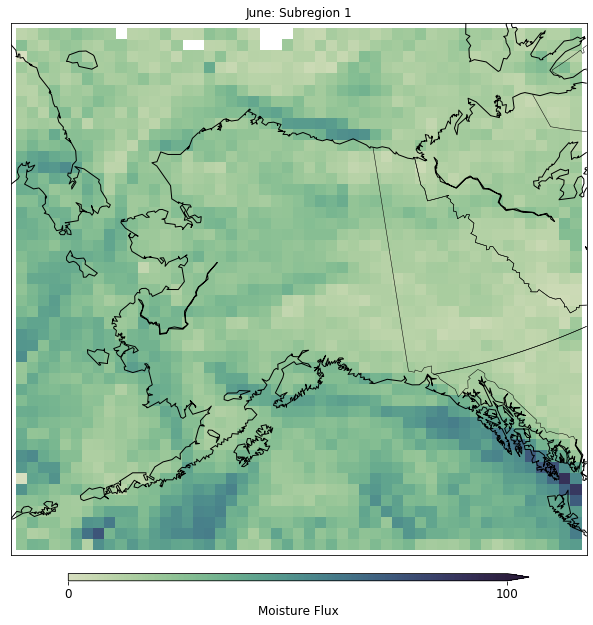

In [10]:
fig = plt.figure(figsize=(8.,9.))
ax = fig.add_axes([0.0, 0., 1., 1.]) 

ax.set_title('June: Subregion 1', fontsize=12)
#Central Interior

pc = m.pcolormesh(ds.lons.values, ds.lats.values, np.ma.masked_where(ds.frequency==0, ds.moisture_flux), 
                  cmap=cmap, vmin=0, vmax=100)

m.drawstates()
m.drawcoastlines()
m.drawcountries()

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.01125])
bounds = [0,100]
newnorm=mpl.colors.Normalize(vmin=0,vmax=100)
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                 norm=newnorm,
                                 ticks=bounds,
                                 orientation='horizontal',
                                 extend='max')

cbar.set_label('Moisture Flux', fontsize=12) 
cbar.ax.tick_params(labelsize=12)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')
                   
plt.show()

In [112]:
trajgroup = pysplit.make_trajectorygroup(f'/glade/scratch/molina/basile/hist_traj/trajid*_subregion3_ens*_jun*summer*')

x_trajs = np.array([np.array(traj.path.coords[:])[::,0][j] for traj in trajgroup for j in range(len(traj.path.coords[:]))]).flatten()
y_trajs = np.array([np.array(traj.path.coords[:])[::,1][j] for traj in trajgroup for j in range(len(traj.path.coords[:]))]).flatten()
x_proj, y_proj = m(x_trajs, y_trajs)
#specific_humidity = np.array([traj.data.Specific_Humidity.astype(np.float64).values[j] for traj in good_group for j in xrange(len(traj.data.Specific_Humidity.astype(np.float64).values))]).flatten()
freq_grid, _, _ = np.histogram2d(y_proj, x_proj, bins=(yi, xi))  

y = np.zeros(len(yi)-1)
x = np.zeros(len(xi)-1)
for a in range(len(y)):
    y[a] = np.nanmean([yi[a],yi[a+1]])
for b in range(len(x)):
    x[b] = np.nanmean([xi[b],xi[b+1]])

ds3 = xr.Dataset({'frequency':(['lats','lons'],freq_grid)},
                 coords={'lats':(['lats'],y),
                         'lons':(['lons'],x)},
                 attrs={'Trajectories and File Author':'Maria J. Molina',
                        'Trajectory Count':str(trajgroup.trajcount),
                        'Coordinate Units':'map projection coordinates'})

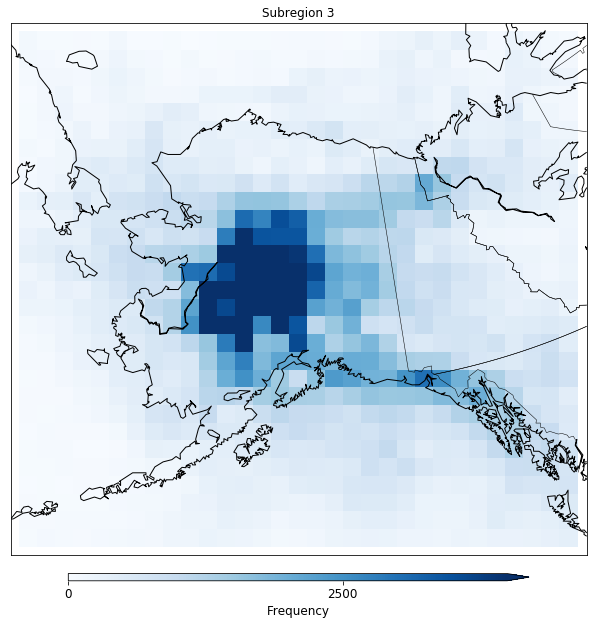

In [122]:
fig = plt.figure(figsize=(8.,9.))
ax = fig.add_axes([0.0, 0., 1., 1.]) 

ax.set_title('Subregion 3', fontsize=12)
#Central Interior

pc = m.pcolormesh(ds3.lons.values, ds3.lats.values, ds3.frequency, cmap="Blues", vmin=0, vmax=2500)

m.drawstates()
m.drawcoastlines()
m.drawcountries()

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.01125])
bounds = [0,2500]
newnorm=mpl.colors.Normalize(vmin=0,vmax=4000)
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=plt.cm.get_cmap("Blues"),
                                 norm=newnorm,
                                 ticks=bounds,
                                 orientation='horizontal',
                                 extend='max')

cbar.set_label('Frequency', fontsize=12) 
cbar.ax.tick_params(labelsize=12)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')
                   
plt.show()

In [123]:
trajgroup = pysplit.make_trajectorygroup(f'/glade/scratch/molina/basile/hist_traj/trajid*_subregion4_ens*_jun*summer*')

x_trajs = np.array([np.array(traj.path.coords[:])[::,0][j] for traj in trajgroup for j in range(len(traj.path.coords[:]))]).flatten()
y_trajs = np.array([np.array(traj.path.coords[:])[::,1][j] for traj in trajgroup for j in range(len(traj.path.coords[:]))]).flatten()
x_proj, y_proj = m(x_trajs, y_trajs)
#specific_humidity = np.array([traj.data.Specific_Humidity.astype(np.float64).values[j] for traj in good_group for j in xrange(len(traj.data.Specific_Humidity.astype(np.float64).values))]).flatten()
freq_grid, _, _ = np.histogram2d(y_proj, x_proj, bins=(yi, xi))  

y = np.zeros(len(yi)-1)
x = np.zeros(len(xi)-1)
for a in range(len(y)):
    y[a] = np.nanmean([yi[a],yi[a+1]])
for b in range(len(x)):
    x[b] = np.nanmean([xi[b],xi[b+1]])

ds4 = xr.Dataset({'frequency':(['lats','lons'],freq_grid)},
                 coords={'lats':(['lats'],y),
                         'lons':(['lons'],x)},
                 attrs={'Trajectories and File Author':'Maria J. Molina',
                        'Trajectory Count':str(trajgroup.trajcount),
                        'Coordinate Units':'map projection coordinates'})

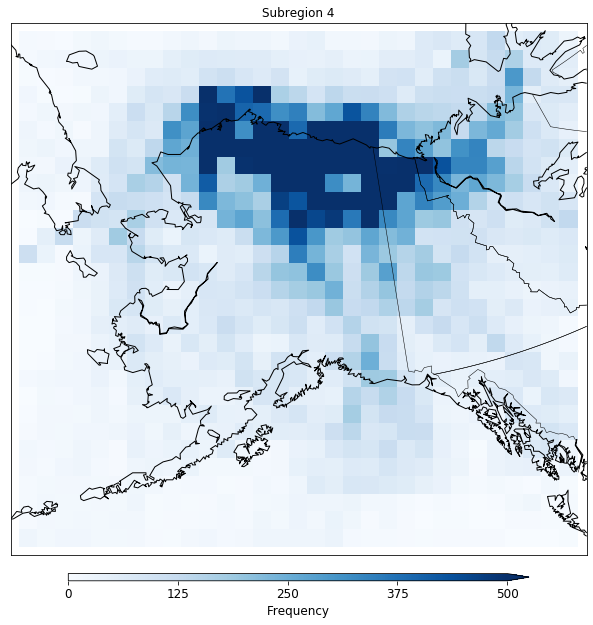

In [132]:
fig = plt.figure(figsize=(8.,9.))
ax = fig.add_axes([0.0, 0., 1., 1.]) 

ax.set_title('Subregion 4', fontsize=12)
#Central Interior

pc = m.pcolormesh(ds4.lons.values, ds4.lats.values, ds4.frequency, cmap="Blues", vmin=0, vmax=500)

m.drawstates()
m.drawcoastlines()
m.drawcountries()

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.01125])
bounds = [0,125,250,375,500]
newnorm=mpl.colors.Normalize(vmin=0,vmax=500)
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=plt.cm.get_cmap("Blues"),
                                 norm=newnorm,
                                 ticks=bounds,
                                 orientation='horizontal',
                                 extend='max')

cbar.set_label('Frequency', fontsize=12) 
cbar.ax.tick_params(labelsize=12)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')
                   
plt.show()

In [124]:
trajgroup = pysplit.make_trajectorygroup(f'/glade/scratch/molina/basile/hist_traj/trajid*_subregion5_ens*_jun*summer*')

x_trajs = np.array([np.array(traj.path.coords[:])[::,0][j] for traj in trajgroup for j in range(len(traj.path.coords[:]))]).flatten()
y_trajs = np.array([np.array(traj.path.coords[:])[::,1][j] for traj in trajgroup for j in range(len(traj.path.coords[:]))]).flatten()
x_proj, y_proj = m(x_trajs, y_trajs)
#specific_humidity = np.array([traj.data.Specific_Humidity.astype(np.float64).values[j] for traj in good_group for j in xrange(len(traj.data.Specific_Humidity.astype(np.float64).values))]).flatten()
freq_grid, _, _ = np.histogram2d(y_proj, x_proj, bins=(yi, xi))  

y = np.zeros(len(yi)-1)
x = np.zeros(len(xi)-1)
for a in range(len(y)):
    y[a] = np.nanmean([yi[a],yi[a+1]])
for b in range(len(x)):
    x[b] = np.nanmean([xi[b],xi[b+1]])

ds5 = xr.Dataset({'frequency':(['lats','lons'],freq_grid)},
                 coords={'lats':(['lats'],y),
                         'lons':(['lons'],x)},
                 attrs={'Trajectories and File Author':'Maria J. Molina',
                        'Trajectory Count':str(trajgroup.trajcount),
                        'Coordinate Units':'map projection coordinates'})

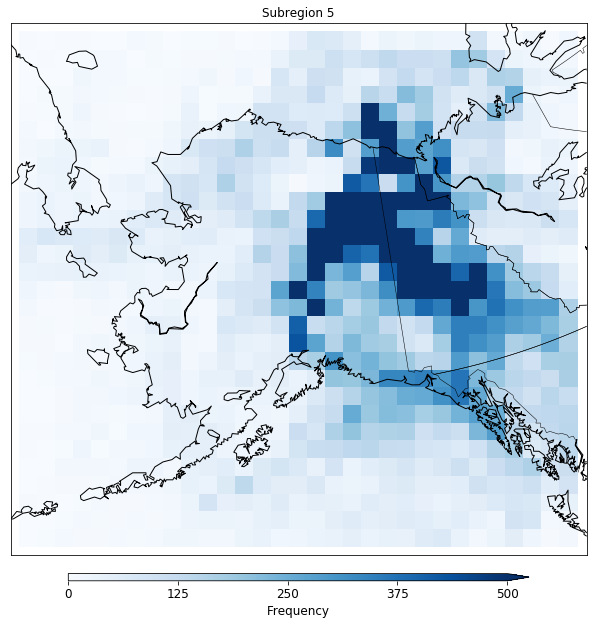

In [131]:
fig = plt.figure(figsize=(8.,9.))
ax = fig.add_axes([0.0, 0., 1., 1.]) 

ax.set_title('Subregion 5', fontsize=12)
#Central Interior

pc = m.pcolormesh(ds5.lons.values, ds5.lats.values, ds5.frequency, cmap="Blues", vmin=0, vmax=500)

m.drawstates()
m.drawcoastlines()
m.drawcountries()

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.01125])
bounds = [0,125,250,375,500]
newnorm=mpl.colors.Normalize(vmin=0,vmax=500)
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=plt.cm.get_cmap("Blues"),
                                 norm=newnorm,
                                 ticks=bounds,
                                 orientation='horizontal',
                                 extend='max')

cbar.set_label('Frequency', fontsize=12) 
cbar.ax.tick_params(labelsize=12)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')
                   
plt.show()

In [125]:
trajgroup = pysplit.make_trajectorygroup(f'/glade/scratch/molina/basile/hist_traj/trajid*_subregion6_ens*_jun*summer*')

x_trajs = np.array([np.array(traj.path.coords[:])[::,0][j] for traj in trajgroup for j in range(len(traj.path.coords[:]))]).flatten()
y_trajs = np.array([np.array(traj.path.coords[:])[::,1][j] for traj in trajgroup for j in range(len(traj.path.coords[:]))]).flatten()
x_proj, y_proj = m(x_trajs, y_trajs)
#specific_humidity = np.array([traj.data.Specific_Humidity.astype(np.float64).values[j] for traj in good_group for j in xrange(len(traj.data.Specific_Humidity.astype(np.float64).values))]).flatten()
freq_grid, _, _ = np.histogram2d(y_proj, x_proj, bins=(yi, xi))  

y = np.zeros(len(yi)-1)
x = np.zeros(len(xi)-1)
for a in range(len(y)):
    y[a] = np.nanmean([yi[a],yi[a+1]])
for b in range(len(x)):
    x[b] = np.nanmean([xi[b],xi[b+1]])

ds6 = xr.Dataset({'frequency':(['lats','lons'],freq_grid)},
                 coords={'lats':(['lats'],y),
                         'lons':(['lons'],x)},
                 attrs={'Trajectories and File Author':'Maria J. Molina',
                        'Trajectory Count':str(trajgroup.trajcount),
                        'Coordinate Units':'map projection coordinates'})

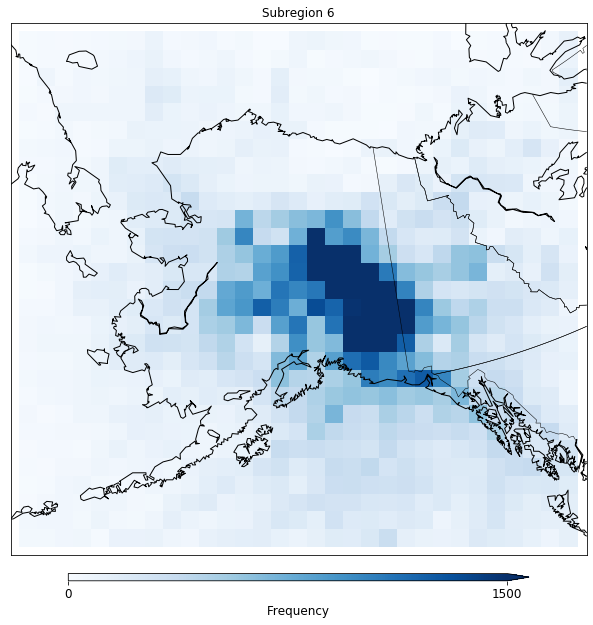

In [129]:
fig = plt.figure(figsize=(8.,9.))
ax = fig.add_axes([0.0, 0., 1., 1.]) 

ax.set_title('Subregion 6', fontsize=12)
#Central Interior

pc = m.pcolormesh(ds6.lons.values, ds6.lats.values, ds6.frequency, cmap="Blues", vmin=0, vmax=1500)

m.drawstates()
m.drawcoastlines()
m.drawcountries()

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.01125])
bounds = [0,1500]
newnorm=mpl.colors.Normalize(vmin=0,vmax=1500)
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=plt.cm.get_cmap("Blues"),
                                 norm=newnorm,
                                 ticks=bounds,
                                 orientation='horizontal',
                                 extend='max')

cbar.set_label('Frequency', fontsize=12) 
cbar.ax.tick_params(labelsize=12)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')
                   
plt.show()